In [1]:
import json
import numpy as np
from openai import OpenAI, AsyncOpenAI
from order_by.sorting import *
from order_by.utils import *
from prompts.all_prompts import *
import openai
from collections import defaultdict
import pytrec_eval
from string import Template
from order_by.pointwise import *
import pytrec_eval
import random
print(openai.__version__)
# client = OpenAI(api_key=api_key)
apikey = 
client = AsyncOpenAI(api_key=apikey)
random.seed(0)

1.90.0


In [2]:
from dataclasses import dataclass
from tqdm import tqdm

@dataclass
class SearchResult:
    docid: str
    score: float
    text: str

In [3]:
# import datasets

# data = datasets.load_dataset("ms_marco", "v1.1", split="train")
# sampled_data = data.shuffle(seed=42).select(range(100))

# data_list = [dict(item) for item in sampled_data]
# with open("msmarco_v1.1_sampled_100.json", "w") as f:
#     json.dump(data_list, f, indent=2)

# print("Saved to 'msmarco_v1.1_sampled_100.json'")



import ir_datasets

# # Discover all available msmarco-passage-v2 variants
# for d in ir_datasets.registry:
#     if "msmarco-passage" in d:
#         print(d)


# Load TREC DL 2019 with MS MARCO v1 passage corpus
ds = ir_datasets.load("msmarco-passage/trec-dl-2019")



In [4]:
print("Docs:", ds.docs_count())      # Number of docs
print("Queries:", ds.queries_count())# Number of queries
print("Qrels:", ds.qrels_count())    # Number of qrels

passage_length = 1024
query_map = {}
for query in ds.queries_iter():
    # query.query_id → string ID
    # query.text → raw query text
    gpt_encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    query_map[query.query_id] = gpt_encoding.decode( gpt_encoding.encode(query.text)[:passage_length] )
print(len(query_map))


Docs: 8841823
Queries: 200
Qrels: 9260
200


In [5]:
doc_lookup = {}
for doc in ds.docs_iter():
    doc_lookup[doc.doc_id] = {
        "contents": doc.text
    }
    # Add title if it exists in dataset (some have no title)
    if hasattr(doc, "title") and doc.title:
        doc_lookup[doc.doc_id]["title"] = doc.title

In [6]:
bm25_dl19_txt = 'data/run.msmarco-v1-passage.bm25-default.dl19.txt'
def load_run_file(path, query_map, doc_lookup, hits=100):
    first_stage_rankings = []
    query_id_to_list = defaultdict(list)
    with open(path, 'r') as f:
        current_qid = None
        current_ranking = []
        for line in tqdm(f):
            qid, _, docid, _, score, _ = line.strip().split()
            if qid not in query_map:
                print(qid)
                print('???')
                continue
                
            doc_data = doc_lookup[docid]
            text = doc_data["contents"]
            if "title" in doc_data:
                text = f'{doc_data["title"]} {text}'
            text = gpt_encoding.decode(gpt_encoding.encode(text)[:passage_length])
            
            query_id_to_list[qid].append(SearchResult(docid=docid, score=float(score), text=text))
            
    for qid, current_ranking in query_id_to_list.items():
        first_stage_rankings.append((qid, query_map[qid], current_ranking[:hits]))
    return first_stage_rankings

In [7]:
first_stage_rankings = load_run_file(bm25_dl19_txt, query_map, doc_lookup, 100)
print(len(first_stage_rankings ))

43000it [00:04, 9107.08it/s] 

43


# Filter with BM25

In [9]:
class SafeDict(dict):
    def __missing__(self, k):  # leave untouched
        return '{' + k + '}'

In [10]:


# Build qrels dict
qrels_by_qid = defaultdict(dict)
for q in ds.qrels_iter():                      # has query_id, doc_id, relevance
    qrels_by_qid[str(q.query_id)][str(q.doc_id)] = int(q.relevance)
qrels_by_qid = dict(qrels_by_qid)

evaluator = pytrec_eval.RelevanceEvaluator(qrels_by_qid, {'ndcg_cut.10'})

bm25_run = {}
for qid, query, ranking in first_stage_rankings:
    bm25_run[str(qid)] = {str(r.docid): float(r.score) for r in ranking}

metrics = evaluator.evaluate(bm25_run)
print(metrics[str('19335')]['ndcg_cut_10'])  # per-query
mean_ndcg10 = sum(m['ndcg_cut_10'] for m in metrics.values()) / len(metrics)
print("BM25 Mean nDCG@10:", mean_ndcg10)

0.5755597276220168
BM25 Mean nDCG@10: 0.505831002439907


In [11]:
# print(qrels_by_qid['19335'])
# print(bm25_run['19335'])

# Pointwise experiments

In [12]:
results = {}

for modelname in ["gpt-4o-mini", "gpt-4o"]:
    results[modelname] = {}
    run = {}
    total_tokens = 0
    for qid, query, ranking in tqdm(first_stage_rankings):
        passage_list = []
        for r in ranking:
            passage_list.append( (r.docid, r.text) ) 
            
        # print(ranking) # docid, score, text
        pointwise_prompt_template = passage_pointwise_prompt_template.format_map(SafeDict(question=query))

        sorted_data, scores, num_api_calls, tokens, confidences =\
            await pointwise_sort(passage_list, client, pointwise_prompt_template,
                                 modelname, float, PointwiseRelevanceKey)
        run[str(qid)] = {str(doc_id): float(score) for doc_id, score in zip(sorted_data, scores)}
        total_tokens += tokens
    metrics = evaluator.evaluate(run)
    mean_pointwise = sum(m['ndcg_cut_10'] for m in metrics.values()) / len(metrics)
    print(f"{modelname}, pointwise Mean nDCG@10:", mean_pointwise)
    print(f"tokens: {total_tokens}")
    
    run = {}
    total_tokens = 0
    for qid, query, ranking in tqdm(first_stage_rankings):
        print(qid, query)
        passage_list = []
        for r in ranking:
            passage_list.append( (r.docid, r.text) )
        external_pointwise_prompt_template = passage_external_pointwise_prompt_template.format_map(SafeDict(question=query))
        sorted_data, scores, num_api_calls, tokens, confidences, _ =\
            await external_pointwise_sort(passage_list, external_values, client, external_pointwise_prompt_template,\
                                          modelname, float, 0.1, isPassage=True)
        run[str(qid)] = {str(doc_id): float(score) for doc_id, score in zip(sorted_data, scores)}
        total_tokens += tokens
    metrics = evaluator.evaluate(run)
    mean_external_pointwise = sum(m['ndcg_cut_10'] for m in metrics.values()) / len(metrics)
    print(f"{modelname}, extrernal pointwise Mean nDCG@10:", mean_external_pointwise)
    print(f"tokens: {total_tokens}")

100%|███████████████████████████████████████████| 43/43 [00:00<00:00, 48.90it/s]


gpt-4o-mini, pointwise Mean nDCG@10: 0.7028129447420369
tokens: 1610518


 35%|██████████████▋                           | 15/43 [00:00<00:00, 147.40it/s]

19335 anthropological definition of environment
from window m=2: 1.5 from window 2*m: 2.0
from window m=2: 2.5 from window 2*m: 3.0
from window m=4: 2.5 from window 2*m: 3.0
from window m=4: 3.0 from window 2*m: 2.5
from window m=4: 1.5 from window 2*m: 2.5
from window m=4: 1.5 from window 2*m: 2.5
from window m=4: 2.5 from window 2*m: 2.0
from window m=4: 0.0 from window 2*m: 1.0
Final memory size for external pointwise: m = 4 (agreement = 0.25)
47923 axon terminals or synaptic knob definition
from window m=2: 1.5 from window 2*m: 3.0
from window m=2: 3.0 from window 2*m: 2.5
from window m=4: 1.5 from window 2*m: 2.0
from window m=4: 2.5 from window 2*m: 3.0
from window m=4: 1.5 from window 2*m: 1.0
from window m=4: 2.5 from window 2*m: 2.0
from window m=8: 2.0 from window 2*m: 1.5
from window m=8: 2.0 from window 2*m: 3.0
from window m=8: 2.0 from window 2*m: 2.5
from window m=8: 1.5 from window 2*m: 2.0
from window m=8: 1.5 from window 2*m: 3.0
Final memory size for external pointwi

1106007 define visceral?


100%|██████████████████████████████████████████| 43/43 [00:00<00:00, 145.72it/s]


from window m=2: 2.5 from window 2*m: 1.5
from window m=4: 1.5 from window 2*m: 1.0
from window m=4: 1.5 from window 2*m: 1.0
from window m=4: 0.5 from window 2*m: 1.0
from window m=4: 2.5 from window 2*m: 1.5
from window m=4: 2.5 from window 2*m: 1.0
Final memory size for external pointwise: m = 4 (agreement = 0.38)
1110199 what is wifi vs bluetooth
from window m=2: 1.5 from window 2*m: 0.0
from window m=4: 0.0 from window 2*m: 1.0
from window m=4: 3.0 from window 2*m: 2.5
from window m=4: 0.0 from window 2*m: 0.5
from window m=8: 1.0 from window 2*m: 0.5
from window m=8: 1.0 from window 2*m: 0.0
from window m=8: 0.5 from window 2*m: 0.0
from window m=8: 0.5 from window 2*m: 0.0
from window m=8: 0.5 from window 2*m: 0.0
from window m=8: 0.5 from window 2*m: 0.0
from window m=8: 0.5 from window 2*m: 0.0
from window m=8: 2.5 from window 2*m: 1.0
from window m=8: 0.5 from window 2*m: 0.0
Final memory size for external pointwise: m = 8 (agreement = 0.44)
1112341 what is the daily life of 

100%|███████████████████████████████████████████| 43/43 [00:00<00:00, 70.68it/s]


gpt-4o, pointwise Mean nDCG@10: 0.6851303581701533
tokens: 1807430


 47%|███████████████████▌                      | 20/43 [00:00<00:00, 190.73it/s]

19335 anthropological definition of environment
from window m=2: 2.5 from window 2*m: 3.0
from window m=2: 1.5 from window 2*m: 2.5
from window m=2: 0.5 from window 2*m: 0.0
Final memory size for external pointwise: m = 2 (agreement = 0.25)
47923 axon terminals or synaptic knob definition
from window m=2: 3.0 from window 2*m: 2.5
from window m=4: 2.5 from window 2*m: 3.0
from window m=4: 2.0 from window 2*m: 2.5
from window m=4: 3.0 from window 2*m: 2.5
from window m=4: 3.0 from window 2*m: 2.0
from window m=4: 2.0 from window 2*m: 2.5
from window m=4: 2.5 from window 2*m: 2.0
Final memory size for external pointwise: m = 4 (agreement = 0.25)
87181 causes of left ventricular hypertrophy
from window m=2: 3.0 from window 2*m: 2.5
from window m=8: 2.5 from window 2*m: 3.0
from window m=8: 2.5 from window 2*m: 3.0
from window m=8: 0.5 from window 2*m: 1.0
from window m=8: 0.5 from window 2*m: 1.0
from window m=8: 1.0 from window 2*m: 0.5
from window m=16: 1.0 from window 2*m: 0.5
from wind

from window m=8: 0.0 from window 2*m: 0.5
from window m=8: 2.0 from window 2*m: 2.5
from window m=8: 1.0 from window 2*m: 0.5
from window m=8: 0.0 from window 2*m: 0.5
from window m=8: 0.0 from window 2*m: 0.5
from window m=8: 1.0 from window 2*m: 1.5
from window m=8: 1.0 from window 2*m: 0.5
from window m=8: 3.0 from window 2*m: 2.5


100%|██████████████████████████████████████████| 43/43 [00:00<00:00, 181.39it/s]

from window m=16: 1.5 from window 2*m: 2.5
from window m=16: 1.0 from window 2*m: 0.5
from window m=16: 0.0 from window 2*m: 0.5
from window m=16: 0.0 from window 2*m: 0.5
from window m=16: 1.0 from window 2*m: 0.5
from window m=16: 1.0 from window 2*m: 0.5
from window m=16: 2.0 from window 2*m: 0.5
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 2.5 from window 2*m: 1.5
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 1.5 from window 2*m: 0.0
from window m=32: 3.0 from window 2*m: 0.0
from window m=32: 3.0 from window 2*m: 1.5
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 3.0 from window 2*m: 1.5
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 0.5 from window 2*m: 0.0
from window m=32: 0.5 from window 2*m: 0.0
from window

# Pairwise experiments

In [13]:
print('start')

start


In [14]:
results = {}

for modelname in ["gpt-4o-mini", "gpt-4o"]:        
    results[modelname] = {}
    run = {}
    total_tokens = 0
    for qid, query, ranking in tqdm(first_stage_rankings):
        print(qid)
        passage_list = []
        for r in ranking:
            passage_list.append( (r.docid, r.text) ) 
            
        pairwise_comparison_prompt_template = passage_pairwise_comparison_prompt_template.format_map(SafeDict(question=query))
        vote = 1
        sorted_data, num_api_calls, tokens =\
            await quick_sort(passage_list, client, pairwise_comparison_prompt_template, modelname, True, vote)
        run[str(qid)] = {
            str(doc_id): float(1.0 * i / (len(sorted_data) - 1))
            for (doc_id, text), i in zip( sorted_data, range(len(sorted_data)) )
        }
        total_tokens += tokens
    metrics = evaluator.evaluate(run)
    mean_pointwise = sum(m['ndcg_cut_10'] for m in metrics.values()) / len(metrics)
    print(f"{modelname}, quick_sort Mean nDCG@10:", mean_pointwise)
    print(f"tokens: {total_tokens}")
    
    run = {}
    total_tokens = 0
    for qid, query, ranking in tqdm(first_stage_rankings):
        print(qid)
        passage_list = []
        for r in ranking:
            passage_list.append( (r.docid, r.text) ) 
            
        pairwise_comparison_prompt_template = passage_pairwise_comparison_prompt_template.format_map(SafeDict(question=query))
        vote = 3
        sorted_data, num_api_calls, tokens =\
            await quick_sort(passage_list, client, pairwise_comparison_prompt_template, modelname, True, vote)
        run[str(qid)] = {
            str(doc_id): float(1.0 * i / (len(sorted_data) - 1))
            for (doc_id, text), i in zip( sorted_data, range(len(sorted_data)) )
        }
        total_tokens += tokens
    metrics = evaluator.evaluate(run)
    mean_pointwise = sum(m['ndcg_cut_10'] for m in metrics.values()) / len(metrics)
    print(f"{modelname}, quick_sort with vote={vote} Mean nDCG@10:", mean_pointwise)
    print(f"tokens: {total_tokens}")
    

  2%|█                                           | 1/43 [00:00<00:05,  7.09it/s]

19335
47923
87181


 12%|█████                                       | 5/43 [00:00<00:02, 13.43it/s]

87452
104861
130510


 16%|███████▏                                    | 7/43 [00:00<00:02, 12.47it/s]

131843
146187
148538


 21%|█████████▏                                  | 9/43 [00:00<00:02, 12.71it/s]

156493


 30%|█████████████                              | 13/43 [00:02<00:05,  5.14it/s]

168216
182539
183378
207786


 40%|█████████████████                          | 17/43 [00:02<00:03,  8.39it/s]

264014
359349
405717
443396


 49%|█████████████████████                      | 21/43 [00:02<00:01, 11.80it/s]

451602
489204
490595
527433


 58%|█████████████████████████                  | 25/43 [00:02<00:01, 13.67it/s]

573724
833860
855410
915593


 67%|█████████████████████████████              | 29/43 [00:02<00:00, 15.66it/s]

962179
1037798
1063750
1103812


 77%|█████████████████████████████████          | 33/43 [00:03<00:00, 17.10it/s]

1106007
1110199
1112341
1113437
1114646


 88%|██████████████████████████████████████     | 38/43 [00:03<00:00, 18.43it/s]

1114819
1115776
1117099
1121402


 98%|██████████████████████████████████████████ | 42/43 [00:03<00:00, 18.52it/s]

1121709
1124210
1129237
1133167


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.54it/s]


gpt-4o-mini, quick_sort Mean nDCG@10: 0.7094846436237204
tokens: 15159756


  0%|                                                    | 0/43 [00:00<?, ?it/s]

19335


  2%|▉                                        | 1/43 [02:40<1:52:10, 160.25s/it]

47923


  5%|█▉                                       | 2/43 [04:54<1:39:13, 145.20s/it]

87181


  7%|██▊                                      | 3/43 [06:18<1:18:00, 117.01s/it]

87452


  9%|███▊                                     | 4/43 [08:27<1:19:14, 121.91s/it]

104861


 12%|█████                                       | 5/43 [09:12<59:41, 94.24s/it]

130510


 14%|█████▋                                   | 6/43 [14:24<1:43:36, 168.03s/it]

131843


 16%|██████▋                                  | 7/43 [18:27<1:55:29, 192.48s/it]

146187


 19%|███████▋                                 | 8/43 [22:22<2:00:15, 206.15s/it]

148538


 21%|████████▌                                | 9/43 [23:37<1:33:40, 165.31s/it]

156493


 23%|█████████▎                              | 10/43 [25:02<1:17:13, 140.41s/it]

168216


 26%|██████████▋                               | 11/43 [25:39<57:58, 108.69s/it]

182539


 28%|███████████▏                            | 12/43 [29:47<1:18:02, 151.04s/it]

183378


 30%|████████████                            | 13/43 [31:19<1:06:34, 133.15s/it]

207786
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 55 [type=json_invalid, input_value='{"steps":[{"explanation"...e A discusses metabolic', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 33%|█████████████                           | 14/43 [33:48<1:06:42, 138.02s/it]

264014


 35%|██████████████▋                           | 15/43 [34:34<51:28, 110.31s/it]

359349


 37%|███████████████▋                          | 16/43 [37:03<54:54, 122.01s/it]

405717


 40%|████████████████▌                         | 17/43 [37:59<44:12, 102.03s/it]

443396


 42%|████████████████▋                       | 18/43 [42:55<1:06:51, 160.48s/it]

451602


 44%|██████████████████▌                       | 19/43 [44:40<57:25, 143.57s/it]

489204


 47%|███████████████████▌                      | 20/43 [47:31<58:16, 152.03s/it]

490595


 49%|███████████████████▌                    | 21/43 [51:32<1:05:32, 178.74s/it]

527433


 51%|████████████████████▍                   | 22/43 [56:41<1:16:12, 217.73s/it]

573724


 53%|████████████████████▎                 | 23/43 [1:01:16<1:18:17, 234.90s/it]

833860


 56%|█████████████████████▏                | 24/43 [1:06:11<1:20:03, 252.82s/it]

855410


 58%|██████████████████████                | 25/43 [1:14:05<1:35:46, 319.26s/it]

915593


 60%|██████████████████████▉               | 26/43 [1:16:29<1:15:32, 266.62s/it]

962179


 63%|███████████████████████▊              | 27/43 [1:20:04<1:07:01, 251.33s/it]

1037798


 65%|████████████████████████▋             | 28/43 [1:27:19<1:16:34, 306.31s/it]

1063750


 67%|█████████████████████████▋            | 29/43 [1:31:00<1:05:30, 280.75s/it]

1103812


 70%|██████████████████████████▌           | 30/43 [1:41:49<1:24:47, 391.32s/it]

1106007


 72%|███████████████████████████▍          | 31/43 [1:45:50<1:09:13, 346.11s/it]

1110199


 74%|████████████████████████████▎         | 32/43 [1:55:58<1:17:52, 424.79s/it]

1112341


 77%|█████████████████████████████▏        | 33/43 [2:06:49<1:22:06, 492.64s/it]

1113437
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 12 [type=json_invalid, input_value='{"steps":[{"', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 79%|██████████████████████████████        | 34/43 [2:11:59<1:05:38, 437.63s/it]

1114646


 81%|████████████████████████████████▌       | 35/43 [2:15:56<50:21, 377.70s/it]

1114819


 84%|█████████████████████████████████▍      | 36/43 [2:25:26<50:46, 435.17s/it]

1115776
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 419 [type=json_invalid, input_value='{"steps":[{"explanation"...er context, but it does', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing an object at line 1 column 983 [type=json_invalid, input_value='{"steps":[{"explanation"... relate to AML at all."', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 86%|██████████████████████████████████▍     | 37/43 [2:38:39<54:15, 542.63s/it]

1117099


 88%|███████████████████████████████████▎    | 38/43 [2:47:55<45:32, 546.50s/it]

1121402


 91%|████████████████████████████████████▎   | 39/43 [2:56:53<36:15, 543.93s/it]

1121709
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 98 [type=json_invalid, input_value='{"steps":[{"explanation"... of small-cap and large', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 461 [type=json_invalid, input_value='{"steps":[{"explanation"...I will select Passage A', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 93%|█████████████████████████████████████▏  | 40/43 [3:06:37<27:48, 556.02s/it]

1124210


 95%|██████████████████████████████████████▏ | 41/43 [3:11:13<15:44, 472.19s/it]

1129237


 98%|███████████████████████████████████████ | 42/43 [3:18:21<07:38, 458.88s/it]

1133167


100%|████████████████████████████████████████| 43/43 [3:21:06<00:00, 280.62s/it]


gpt-4o-mini, quick_sort with vote=3 Mean nDCG@10: 0.6936372313078706
tokens: 33539392


  5%|██                                          | 2/43 [00:00<00:03, 10.70it/s]

19335
47923
87181


  9%|████                                        | 4/43 [00:00<00:03, 11.80it/s]

87452
104861
130510


 19%|████████▏                                   | 8/43 [00:00<00:03, 11.55it/s]

131843
146187
148538


 28%|████████████                               | 12/43 [00:00<00:02, 13.50it/s]

156493
168216
182539
183378
207786


 33%|█████████████                           | 14/43 [14:04<1:06:41, 137.97s/it]

264014


 35%|█████████████▉                          | 15/43 [39:02<3:04:30, 395.38s/it]

359349


 37%|██████████████▏                       | 16/43 [1:22:32<6:30:07, 866.93s/it]

405717


 40%|██████████████▋                      | 17/43 [1:49:30<7:31:29, 1041.91s/it]

443396


 42%|███████████████▍                     | 18/43 [2:21:30<8:45:36, 1261.46s/it]

451602


 44%|████████████████▎                    | 19/43 [2:38:34<7:59:37, 1199.05s/it]

489204


 47%|█████████████████▏                   | 20/43 [3:12:20<9:06:09, 1424.76s/it]

490595


 49%|█████████████████▌                  | 21/43 [3:57:53<10:57:07, 1792.14s/it]

527433


 51%|██████████████████▍                 | 22/43 [4:39:07<11:35:32, 1987.25s/it]

573724


 53%|███████████████████▎                | 23/43 [5:02:14<10:04:19, 1812.98s/it]

833860


 56%|████████████████████▋                | 24/43 [5:35:34<9:51:25, 1867.66s/it]

855410
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation="The question asks about the use of 'theraderm.' Passage A discusses the meaning of 'HBY' in slang, which is unrelated to the question. Passage B talks about leveraging personal strengths, which is also unrelated to the question about 'theraderm.' Neither passage answers the question directly."), Step(explanation="Since neither passage addresses the question about 'theraderm,' neither is better in terms of providing an answer.")] BetterPassageKey='' is not contained in [key1, key2]; try again

[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 301 [type=json_invalid, input_value='{"steps":[{"explanation"...m.\'"},{"explanation":"', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: 

 58%|████████████████████▉               | 25/43 [7:20:18<15:51:21, 3171.20s/it]

915593
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 550 [type=json_invalid, input_value='{"steps":[{"explanation"...:"Analyze Passage B: It', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 60%|█████████████████████▊              | 26/43 [7:39:20<12:08:00, 2569.43s/it]

962179
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 61 [type=json_invalid, input_value='{"steps":[{"explanation"... question: The question', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a value at line 1 column 0 [type=json_invalid, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation='Identify the information needed to answer the question. The question asks for the founding date of the Salvation Army.'), Step(explanation='Evaluate Passage A. It provides information about finding Salvation Army locations and customer ratings, but does not mention the founding date.'), Step(explanation='Evaluate Passag

 63%|██████████████████████▌             | 27/43 [9:04:18<14:45:47, 3321.71s/it]

1037798
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation='The question asks about Robert Gray, but Passage A discusses Robert Kraft, a businessman, and Passage B discusses Henry Gray, a musician. Neither passage directly answers the question about Robert Gray.'), Step(explanation='Since neither passage provides information about Robert Gray, neither passage is better in answering the question.')] BetterPassageKey='' is not contained in [key1, key2]; try again

<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation="The question asks for information about 'Robert Gray.' Passage A discusses Emma Roberts and her family connections, while Passage B discusses Robert Downey Jr. Neither passage mentions Robert Gray."), Step(explanation='Since neither passage provides information about Robert Gray, neither passage answers the question.')] BetterPassageKey='' is not contained in [key1, key2]; try again



 65%|███████████████████████▍            | 28/43 [9:38:04<12:13:48, 2935.25s/it]

1063750


 67%|████████████████████████▎           | 29/43 [10:05:44<9:56:01, 2554.39s/it]

1103812


 70%|█████████████████████████           | 30/43 [10:40:41<8:43:45, 2417.32s/it]

1106007


 72%|█████████████████████████▉          | 31/43 [11:16:16<7:46:34, 2332.89s/it]

1110199


 74%|██████████████████████████▊         | 32/43 [11:51:23<6:55:16, 2265.18s/it]

1112341


 77%|███████████████████████████▋        | 33/43 [12:22:15<5:56:54, 2141.48s/it]

1113437
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 115 [type=json_invalid, input_value='{"steps":[{"explanation"...physical description of', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 79%|████████████████████████████▍       | 34/43 [12:52:24<5:06:14, 2041.60s/it]

1114646


 81%|█████████████████████████████▎      | 35/43 [13:25:09<4:29:09, 2018.73s/it]

1114819


 84%|██████████████████████████████▏     | 36/43 [14:17:18<4:34:22, 2351.82s/it]

1115776


 86%|██████████████████████████████▉     | 37/43 [15:09:21<4:18:18, 2583.13s/it]

1117099


 88%|███████████████████████████████▊    | 38/43 [17:00:04<5:16:44, 3800.86s/it]

1121402
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 420 [type=json_invalid, input_value='{"steps":[{"explanation"...ly addresses contour pl', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 91%|████████████████████████████████▋   | 39/43 [18:06:39<4:17:16, 3859.01s/it]

1121709


 93%|█████████████████████████████████▍  | 40/43 [19:21:13<3:22:10, 4043.61s/it]

1124210


 95%|██████████████████████████████████▎ | 41/43 [20:09:04<2:03:03, 3691.73s/it]

1129237
[ERROR] Attempt 1: Request timed out.
[ERROR] Attempt 2: Request timed out.


 98%|███████████████████████████████████▏| 42/43 [21:25:18<1:05:56, 3956.44s/it]

1133167


100%|██████████████████████████████████████| 43/43 [22:51:14<00:00, 1913.37s/it]


gpt-4o, quick_sort Mean nDCG@10: 0.7351607877533932
tokens: 18832854


  0%|                                                    | 0/43 [00:00<?, ?it/s]

19335


  2%|▊                                    | 1/43 [1:11:24<49:59:18, 4284.72s/it]

47923


  5%|█▋                                   | 2/43 [2:09:25<43:24:48, 3811.92s/it]

87181


  7%|██▌                                  | 3/43 [2:41:38<32:49:19, 2953.98s/it]

87452
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation='The question asks about the causes of military suicide. Both passages focus on youth suicide statistics and trends, not military suicide.'), Step(explanation='Neither passage addresses the causes of military suicide, as they both discuss general youth suicide statistics.'), Step(explanation='Since neither passage answers the question about military suicide causes, neither is better in this context.')] BetterPassageKey='' is not contained in [key1, key2]; try again



  9%|███▍                                 | 4/43 [3:19:17<29:01:46, 2679.66s/it]

104861


 12%|████▎                                | 5/43 [3:49:42<25:01:53, 2371.41s/it]

130510


 14%|█████▏                               | 6/43 [4:44:46<27:37:47, 2688.31s/it]

131843
[ERROR] Attempt 1: Request timed out.


 16%|██████                               | 7/43 [6:13:33<35:30:42, 3551.18s/it]

146187


 19%|██████▉                              | 8/43 [7:10:29<34:06:24, 3508.13s/it]

148538


 21%|███████▋                             | 9/43 [7:41:21<28:14:34, 2990.43s/it]

156493


 23%|████████▎                           | 10/43 [8:23:18<26:04:21, 2844.30s/it]

168216


 26%|█████████▏                          | 11/43 [8:57:34<23:08:12, 2602.89s/it]

182539


 28%|██████████                          | 12/43 [9:26:57<20:12:45, 2347.27s/it]

183378


 30%|██████████▉                         | 13/43 [9:52:07<17:26:52, 2093.75s/it]

207786
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 299 [type=json_invalid, input_value='{"steps":[{"explanation"...viding details on their', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 33%|███████████▍                       | 14/43 [11:21:58<24:53:16, 3089.55s/it]

264014
[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 399 [type=json_invalid, input_value='{"steps":[{"explanation"...on":"Passage B provides', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid


 35%|████████████▏                      | 15/43 [11:59:50<22:06:53, 2843.34s/it]

359349


 37%|█████████████                      | 16/43 [13:02:30<23:23:35, 3119.08s/it]

405717


 40%|█████████████▊                     | 17/43 [13:40:50<20:44:57, 2872.96s/it]

443396


 42%|██████████████▋                    | 18/43 [14:36:21<20:54:25, 3010.62s/it]

451602


 44%|███████████████▍                   | 19/43 [15:04:23<17:24:32, 2611.35s/it]

489204


 47%|████████████████▎                  | 20/43 [15:44:45<16:19:17, 2554.68s/it]

490595


 49%|█████████████████                  | 21/43 [16:34:49<16:26:08, 2689.50s/it]

527433


 51%|█████████████████▉                 | 22/43 [17:23:53<16:08:02, 2765.84s/it]

573724


 53%|██████████████████▋                | 23/43 [17:59:50<14:21:05, 2583.28s/it]

833860
[ERROR] Attempt 1: Request timed out.
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation='The question asks about the most popular food in Switzerland. Both passages provided focus on Belgium and its popular foods, not Switzerland.'), Step(explanation='Neither passage A nor passage B provides any information about Switzerland or its popular foods.'), Step(explanation='Since neither passage answers the question about Switzerland, neither can be considered better in this context.')] BetterPassageKey='' is not contained in [key1, key2]; try again

[ERROR] Attempt 1: 1 validation error for PassageComparisonReasoning
  Invalid JSON: EOF while parsing a string at line 1 column 90 [type=json_invalid, input_value='{"steps":[{"explanation"...od in Switzerland."},{"', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
[ERROR] Attempt 1: Request timed out.


 56%|███████████████████▌               | 24/43 [19:16:29<16:49:32, 3188.05s/it]

855410
[ERROR] Attempt 1: Request timed out.


 58%|████████████████████▎              | 25/43 [20:31:43<17:55:44, 3585.83s/it]

915593


 60%|█████████████████████▏             | 26/43 [21:13:03<15:22:00, 3254.12s/it]

962179


 63%|█████████████████████▎            | 27/43 [29:15:20<48:42:28, 10959.30s/it]

1037798


 65%|██████████████████████▊            | 28/43 [30:07:46<35:53:51, 8615.46s/it]

1063750


 67%|███████████████████████▌           | 29/43 [30:40:15<25:43:36, 6615.45s/it]

1103812


 70%|████████████████████████▍          | 30/43 [31:17:43<19:09:25, 5305.02s/it]

1106007


 72%|█████████████████████████▏         | 31/43 [32:01:14<14:59:21, 4496.82s/it]

1110199


 74%|██████████████████████████         | 32/43 [32:45:05<12:01:49, 3937.19s/it]

1112341
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation='The question asks about the daily life of Thai people. We need to determine which passage provides relevant information about this topic.'), Step(explanation='Passage A discusses acts of courage and provides examples of being courageous in daily life. However, it does not specifically address the daily life of Thai people.'), Step(explanation='Passage B talks about occupational therapy and how it helps people perform daily tasks. It does not mention Thai people or their daily life specifically.'), Step(explanation='Neither passage directly answers the question about the daily life of Thai people. However, both passages are unrelated to the specific cultural or daily life context of Thai people.'), Step(explanation='Since neither passage answers the question, we cannot select a better passage based on the given options.')] BetterPassageKey='' is not contained in [key1, key2]; try again


 77%|███████████████████████████▋        | 33/43 [33:11:18<8:57:57, 3227.70s/it]

1113437


 79%|████████████████████████████▍       | 34/43 [33:34:09<6:40:38, 2670.96s/it]

1114646


 81%|█████████████████████████████▎      | 35/43 [34:21:45<6:03:30, 2726.30s/it]

1114819


 84%|██████████████████████████████▏     | 36/43 [35:17:03<5:38:47, 2903.86s/it]

1115776
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation="The question asks about an 'AML surveillance analyst,' which is likely related to financial or regulatory roles, not medical information about leukemia."), Step(explanation='Both passages focus on types of leukemia, specifically Acute Myelogenous Leukemia (AML), and do not address the role of an AML surveillance analyst.'), Step(explanation='Since neither passage provides information relevant to the question about an AML surveillance analyst, neither passage is better in answering the question.')] BetterPassageKey='' is not contained in [key1, key2]; try again



 86%|██████████████████████████████▉     | 37/43 [36:26:32<5:28:19, 3283.25s/it]

1117099


 88%|███████████████████████████████▊    | 38/43 [37:51:41<5:19:15, 3831.17s/it]

1121402
<class 'order_by.pair_comparison.PassageComparisonReasoning'>
output:steps=[Step(explanation="The question asks about what contour plowing can reduce. Both passages provided are about the etymology of the word 'plow' and do not address contour plowing or its effects."), Step(explanation='Since neither passage answers the question about contour plowing, neither Passage A nor Passage B is better in this context.')] BetterPassageKey='' is not contained in [key1, key2]; try again



 91%|████████████████████████████████▋   | 39/43 [38:36:15<3:52:16, 3484.07s/it]

1121709


 93%|█████████████████████████████████▍  | 40/43 [39:24:38<2:45:29, 3309.76s/it]

1124210


 95%|██████████████████████████████████▎ | 41/43 [40:10:09<1:44:31, 3135.97s/it]

1129237


 98%|█████████████████████████████████████ | 42/43 [41:09:13<54:18, 3258.32s/it]

1133167


100%|██████████████████████████████████████| 43/43 [41:35:08<00:00, 3481.59s/it]

gpt-4o, quick_sort with vote=3 Mean nDCG@10: 0.7408057032508985
tokens: 39695995


In [11]:
for modelname in ["gpt-4o"]:    
#     "gpt-4o-mini", 
    memory = [4]
    if "mini" in modelname:
        memory = [4]
    
    for m in memory:
        run = {}
        total_tokens = 0
        for qid, query, ranking in tqdm(first_stage_rankings):
            print(qid)
            passage_list = []
            for r in ranking:
                passage_list.append( (r.docid, r.text) ) 

            external_comparison_prompt_template = passage_external_comparison_prompt_template.format_map(SafeDict(question=query))
            sorted_data, num_api_calls, tokens =\
                await external_bubble_sort(passage_list, external_comparisons, m, client, external_comparison_prompt_template, modelname, True)

            run[str(qid)] = {
                str(doc_id): float(1.0 * i / (len(sorted_data) - 1))
                for (doc_id, text), i in zip( sorted_data, range(len(sorted_data)) )
            }
            total_tokens += tokens
        metrics = evaluator.evaluate(run)
        mean_pointwise = sum(m['ndcg_cut_10'] for m in metrics.values()) / len(metrics)
        print(f"{modelname}, external_bubble_sort Mean nDCG@10:", mean_pointwise)
        print(f"tokens: {total_tokens}")



        run = {}
        total_tokens = 0
        for qid, query, ranking in tqdm(first_stage_rankings):
            print(qid)
            passage_list = []
            for r in ranking:
                passage_list.append( (r.docid, r.text) ) 

            external_comparison_prompt_template = passage_external_comparison_prompt_template.format_map(SafeDict(question=query))
            sorted_data, num_api_calls, tokens =\
                await external_merge_sort(passage_list, external_comparisons, m, client, external_comparison_prompt_template, modelname, True)

            run[str(qid)] = {
                str(doc_id): float(1.0 * i / (len(sorted_data) - 1))
                for (doc_id, text), i in zip( sorted_data, range(len(sorted_data)) )
            }
            total_tokens += tokens
        metrics = evaluator.evaluate(run)
        mean_pointwise = sum(m['ndcg_cut_10'] for m in metrics.values()) / len(metrics)
        print(f"{modelname}, external_merge_sort Mean nDCG@10:", mean_pointwise)
        print(f"tokens: {total_tokens}")


  0%|                                                    | 0/43 [00:00<?, ?it/s]

19335
api call: 1: ISSUE: not the same length as input; try again



  2%|▉                                      | 1/43 [28:12<19:44:39, 1692.38s/it]

47923


  5%|█▋                                   | 2/43 [1:16:58<27:32:23, 2418.13s/it]

87181
api call: 1: ISSUE: not the same length as input; try again



  7%|██▌                                  | 3/43 [1:57:40<26:59:20, 2429.02s/it]

87452
api call: 1: ISSUE: not the same length as input; try again

api call: 1: ISSUE: not the same length as input; try again



  9%|███▍                                 | 4/43 [2:30:40<24:23:35, 2251.67s/it]

104861


 12%|████▎                                | 5/43 [3:14:06<25:06:56, 2379.39s/it]

130510
api call: 1: ISSUE: not the same length as input; try again



 14%|█████▏                               | 6/43 [3:56:53<25:06:45, 2443.38s/it]

131843


 16%|██████                               | 7/43 [4:24:43<21:54:21, 2190.60s/it]

146187
api call: 1: ISSUE: not the same length as input; try again



 19%|██████▉                              | 8/43 [4:56:35<20:26:00, 2101.72s/it]

148538


 21%|███████▋                             | 9/43 [5:40:27<21:25:00, 2267.66s/it]

156493


 23%|████████▎                           | 10/43 [6:31:04<22:57:43, 2504.94s/it]

168216
api call: 1: ISSUE: not the same length as input; try again

api call: 1: ISSUE: not the same length as input; try again



 26%|█████████▏                          | 11/43 [7:27:58<24:44:26, 2783.33s/it]

182539


 28%|██████████                          | 12/43 [8:18:43<24:39:06, 2862.78s/it]

183378
api call: 1: ISSUE: not the same length as input; try again

api call: 1: ISSUE: not the same length as input; try again



 30%|██████████▉                         | 13/43 [9:06:59<23:56:29, 2872.98s/it]

207786


 33%|███████████▋                        | 14/43 [9:26:55<19:03:45, 2366.41s/it]

264014


 35%|████████████▏                      | 15/43 [10:14:05<19:29:34, 2506.25s/it]

359349


 37%|█████████████                      | 16/43 [10:45:24<17:22:51, 2317.45s/it]

405717


 40%|█████████████▊                     | 17/43 [11:38:15<18:35:25, 2574.07s/it]

443396


 42%|██████████████▋                    | 18/43 [12:22:59<18:06:18, 2607.15s/it]

451602


 44%|███████████████▍                   | 19/43 [13:07:02<17:27:05, 2617.73s/it]

489204
api call: 1: ISSUE: not the same length as input; try again



 47%|████████████████▎                  | 20/43 [13:56:57<17:26:56, 2731.17s/it]

490595


 49%|█████████████████                  | 21/43 [14:59:47<18:35:43, 3042.91s/it]

527433


 51%|█████████████████▉                 | 22/43 [15:19:46<14:31:20, 2489.57s/it]

573724


 53%|██████████████████▋                | 23/43 [16:13:58<15:06:04, 2718.23s/it]

833860


 56%|███████████████████▌               | 24/43 [16:37:38<12:17:24, 2328.66s/it]

855410


 58%|████████████████████▉               | 25/43 [16:46:55<8:59:07, 1797.08s/it]

915593


 60%|█████████████████████▊              | 26/43 [17:22:05<8:55:46, 1890.99s/it]

962179


 63%|██████████████████████▌             | 27/43 [17:33:38<6:48:28, 1531.77s/it]

1037798


 65%|███████████████████████▍            | 28/43 [17:58:26<6:19:36, 1518.46s/it]

1063750
api call: 1: ISSUE: not the same length as input; try again



 67%|████████████████████████▎           | 29/43 [18:23:10<5:51:55, 1508.28s/it]

1103812


 70%|█████████████████████████           | 30/43 [18:46:24<5:19:22, 1474.02s/it]

1106007


 72%|█████████████████████████▉          | 31/43 [19:25:59<5:48:49, 1744.12s/it]

1110199


 74%|██████████████████████████▊         | 32/43 [19:58:22<5:30:40, 1803.71s/it]

1112341
api call: 1: ISSUE: not the same length as input; try again



 77%|███████████████████████████▋        | 33/43 [20:28:01<4:59:23, 1796.34s/it]

1113437
api call: 1: ISSUE: not the same length as input; try again



 79%|████████████████████████████▍       | 34/43 [21:02:25<4:41:29, 1876.63s/it]

1114646


 81%|█████████████████████████████▎      | 35/43 [21:43:20<4:33:23, 2050.38s/it]

1114819
api call: 1: ISSUE: not the same length as input; try again



 84%|██████████████████████████████▏     | 36/43 [22:31:38<4:28:52, 2304.62s/it]

1115776


 86%|██████████████████████████████▉     | 37/43 [23:01:30<3:35:05, 2150.84s/it]

1117099
api call: 1: ISSUE: not the same length as input; try again

api call: 1: ISSUE: not the same length as input; try again



 88%|███████████████████████████████▊    | 38/43 [23:34:00<2:54:11, 2090.39s/it]

1121402


 91%|████████████████████████████████▋   | 39/43 [24:14:20<2:25:57, 2189.29s/it]

1121709


 93%|█████████████████████████████████▍  | 40/43 [24:24:15<1:25:33, 1711.24s/it]

1124210
api call: 1: ISSUE: not the same length as input; try again



 95%|██████████████████████████████████▎ | 41/43 [25:36:12<1:23:05, 2492.88s/it]

1129237


 98%|█████████████████████████████████████ | 42/43 [26:09:47<39:09, 2349.49s/it]

1133167


100%|██████████████████████████████████████| 43/43 [27:15:10<00:00, 2281.63s/it]


gpt-4o, external_bubble_sort Mean nDCG@10: 0.7313444288489481
tokens: 38683494


  0%|                                                    | 0/43 [00:00<?, ?it/s]

19335


  2%|▉                                        | 1/43 [04:01<2:49:10, 241.67s/it]

47923


  5%|█▉                                       | 2/43 [10:19<3:39:44, 321.57s/it]

87181


  7%|██▊                                      | 3/43 [15:13<3:26:09, 309.23s/it]

87452


  9%|███▊                                     | 4/43 [18:57<2:58:59, 275.38s/it]

104861
api call: 1: ISSUE: not the same length as input; try again



 12%|████▊                                    | 5/43 [23:41<2:56:20, 278.42s/it]

130510


 14%|█████▋                                   | 6/43 [27:58<2:47:21, 271.40s/it]

131843


 16%|██████▋                                  | 7/43 [31:35<2:32:04, 253.47s/it]

146187
api call: 1: ISSUE: not the same length as input; try again



 19%|███████▋                                 | 8/43 [35:30<2:24:31, 247.75s/it]

148538
[ERROR] Attempt 1: 0


 21%|████████▌                                | 9/43 [40:46<2:32:20, 268.84s/it]

156493


 23%|█████████▎                              | 10/43 [44:59<2:25:09, 263.94s/it]

168216


 26%|██████████▏                             | 11/43 [49:15<2:19:28, 261.52s/it]

182539


 28%|███████████▏                            | 12/43 [53:32<2:14:33, 260.43s/it]

183378


 30%|████████████                            | 13/43 [58:18<2:14:04, 268.14s/it]

207786


 33%|████████████▎                         | 14/43 [1:03:34<2:16:34, 282.57s/it]

264014
api call: 1: ISSUE: not the same length as input; try again



 35%|█████████████▎                        | 15/43 [1:08:40<2:15:03, 289.40s/it]

359349
api call: 1: ISSUE: not the same length as input; try again



 37%|██████████████▏                       | 16/43 [1:12:40<2:03:38, 274.74s/it]

405717


 40%|███████████████                       | 17/43 [1:16:57<1:56:39, 269.20s/it]

443396


 42%|███████████████▉                      | 18/43 [1:22:02<1:56:43, 280.16s/it]

451602


 44%|████████████████▊                     | 19/43 [1:26:58<1:53:56, 284.87s/it]

489204


 47%|█████████████████▋                    | 20/43 [1:32:38<1:55:34, 301.52s/it]

490595


 49%|██████████████████▌                   | 21/43 [1:37:39<1:50:25, 301.14s/it]

527433


 51%|███████████████████▍                  | 22/43 [1:42:42<1:45:37, 301.80s/it]

573724
api call: 1: ISSUE: not the same length as input; try again



 53%|████████████████████▎                 | 23/43 [1:47:27<1:38:53, 296.66s/it]

833860


 56%|█████████████████████▏                | 24/43 [1:52:20<1:33:35, 295.56s/it]

855410


 58%|██████████████████████                | 25/43 [1:56:52<1:26:37, 288.74s/it]

915593


 60%|██████████████████████▉               | 26/43 [2:01:46<1:22:12, 290.15s/it]

962179


 63%|███████████████████████▊              | 27/43 [2:07:21<1:20:56, 303.56s/it]

1037798


 65%|████████████████████████▋             | 28/43 [2:12:59<1:18:30, 314.05s/it]

1063750


 67%|█████████████████████████▋            | 29/43 [2:18:12<1:13:12, 313.72s/it]

1103812


 70%|██████████████████████████▌           | 30/43 [2:23:19<1:07:30, 311.57s/it]

1106007


 72%|███████████████████████████▍          | 31/43 [2:29:01<1:04:09, 320.80s/it]

1110199


 74%|█████████████████████████████▊          | 32/43 [2:33:49<56:59, 310.86s/it]

1112341


 77%|██████████████████████████████▋         | 33/43 [2:38:54<51:30, 309.09s/it]

1113437


 79%|███████████████████████████████▋        | 34/43 [2:44:47<48:21, 322.40s/it]

1114646
api call: 1: ISSUE: not the same length as input; try again



 81%|████████████████████████████████▌       | 35/43 [2:49:31<41:25, 310.71s/it]

1114819


 84%|█████████████████████████████████▍      | 36/43 [2:54:52<36:37, 313.86s/it]

1115776


 86%|██████████████████████████████████▍     | 37/43 [2:59:27<30:12, 302.15s/it]

1117099


 88%|███████████████████████████████████▎    | 38/43 [3:04:45<25:35, 307.11s/it]

1121402


 91%|████████████████████████████████████▎   | 39/43 [3:10:09<20:48, 312.02s/it]

1121709


 93%|█████████████████████████████████████▏  | 40/43 [3:15:48<16:00, 320.13s/it]

1124210


 95%|██████████████████████████████████████▏ | 41/43 [3:21:12<10:42, 321.34s/it]

1129237


 98%|███████████████████████████████████████ | 42/43 [3:26:30<05:20, 320.39s/it]

1133167
api call: 1: ISSUE: not the same length as input; try again



100%|████████████████████████████████████████| 43/43 [3:31:14<00:00, 294.77s/it]

gpt-4o, external_merge_sort Mean nDCG@10: 0.7395685322543967
tokens: 5990003


Fitted parameters:
A = 0.0165
B = 0.6314
x0 = 0.0000


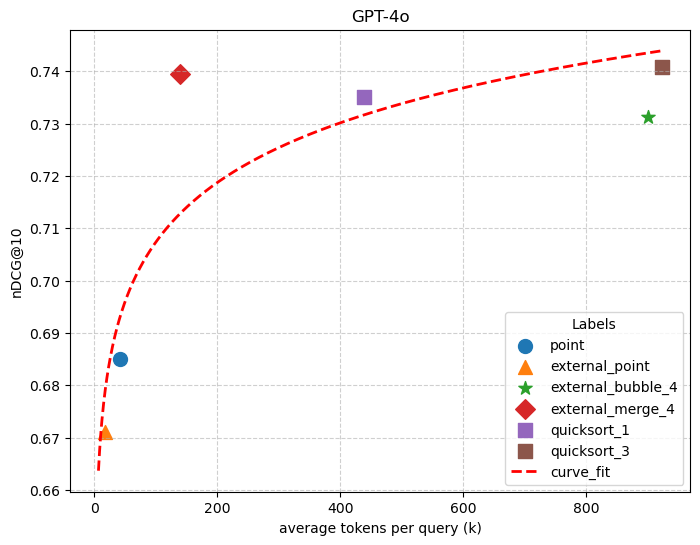

In [28]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

kendalltau = [0.6851303581701533, 0.6710161961426223,
              0.7313444288489481, 0.7395685322543967,
              0.7351607877533932, 0.7408057032508985
             ]
tokens = [1807430, 734876,
          38683494, 5990003,
          18832854, 39695995
         ]
tokens = [t/(43*1000.0) for t in tokens]
dot_labels = ["point", "external_point",\
              "external_bubble_4", "external_merge_4",\
              "quicksort_1", "quicksort_3"
             ]
markers = ['o', '^',\
           '*', 'D',
           's', 's'
          ] 


            
# Create scatter plot
plt.figure(figsize=(8, 6))

for x, y, label, m in zip(tokens, kendalltau, dot_labels, markers):
    plt.scatter(x, y, s=100, marker=m, label=label)



    
def log_linear(x, A, B, x0):
    return A * np.log(x + x0) + B

y_points = kendalltau[:]
x_points = tokens[:]
x_points = np.array(x_points, dtype=float)
y_points = np.array(y_points, dtype=float)
# Initial guess and bounds (ensure x + x0 > 0 ⇒ x0 > -min(x); we keep x0 >= 1e-8)
p0 = [y_points.ptp(), y_points.min(), 0.1]
bounds = ([-np.inf, -np.inf, 1e-8], [np.inf, np.inf, np.inf])

popt, pcov = curve_fit(log_linear, x_points, y_points, p0=p0, bounds=bounds, maxfev=50000)
A, B, x0 = popt

# R^2
y_hat = log_linear(x_points, *popt)
ss_res = np.sum((y_points - y_hat)**2)
ss_tot = np.sum((y_points - y_points.mean())**2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# Smooth curve for plotting
x_fit = np.linspace(x_points.min()-10, x_points.max(), 1000)
y_fit = log_linear(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label="curve_fit")


print("Fitted parameters:")
print(f"A = {A:.4f}")
print(f"B = {B:.4f}")
print(f"x0 = {x0:.4f}")
    

plt.legend(title="Labels")


# Axis labels and title
plt.xlabel("average tokens per query (k)")
plt.ylabel("nDCG@10")
plt.title("GPT-4o")

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Fitted parameters:
A = 0.0095
B = 0.6489
x0 = 0.0000


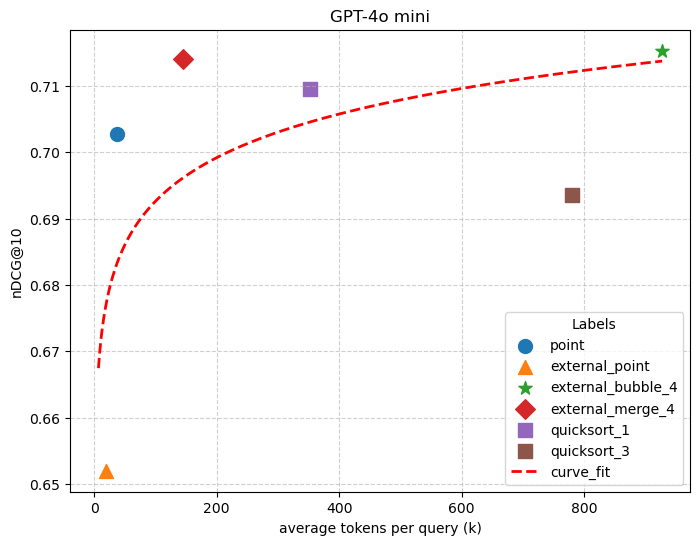

In [29]:
kendalltau = [0.7028129447420369, 0.6520011839194261,
              0.7153217587714527, 0.7140558683618574,
              0.7094846436237204, 0.6936372313078706
             ]
tokens = [1610518, 862804,
          39869401, 6263645,
          15159756, 33539392
         ]
tokens = [t/(43*1000.0) for t in tokens]
dot_labels = ["point", "external_point",\
              "external_bubble_4", "external_merge_4",\
              "quicksort_1", "quicksort_3"
             ]
markers = ['o', '^',\
           '*', 'D',
           's', 's'
          ] 


            
# Create scatter plot
plt.figure(figsize=(8, 6))

for x, y, label, m in zip(tokens, kendalltau, dot_labels, markers):
    plt.scatter(x, y, s=100, marker=m, label=label)



    
def log_linear(x, A, B, x0):
    return A * np.log(x + x0) + B

y_points = kendalltau[:]
x_points = tokens[:]
x_points = np.array(x_points, dtype=float)
y_points = np.array(y_points, dtype=float)
# Initial guess and bounds (ensure x + x0 > 0 ⇒ x0 > -min(x); we keep x0 >= 1e-8)
p0 = [y_points.ptp(), y_points.min(), 0.1]
bounds = ([-np.inf, -np.inf, 1e-8], [np.inf, np.inf, np.inf])

popt, pcov = curve_fit(log_linear, x_points, y_points, p0=p0, bounds=bounds, maxfev=50000)
A, B, x0 = popt

# R^2
y_hat = log_linear(x_points, *popt)
ss_res = np.sum((y_points - y_hat)**2)
ss_tot = np.sum((y_points - y_points.mean())**2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# Smooth curve for plotting
x_fit = np.linspace(x_points.min()-13, x_points.max(), 1000)
y_fit = log_linear(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label="curve_fit")


print("Fitted parameters:")
print(f"A = {A:.4f}")
print(f"B = {B:.4f}")
print(f"x0 = {x0:.4f}")
    

plt.legend(title="Labels")


# Axis labels and title
plt.xlabel("average tokens per query (k)")
plt.ylabel("nDCG@10")
plt.title("GPT-4o mini")

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()